## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [161]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [162]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential, K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

In [163]:
#import Gemma's function for removing outliers
sys.path.insert(0, './../Gemma/Part 1')
from outliers import removeOutliers

#import Riccardo's function for removing missing values
sys.path.insert(0, './../Riccardo')
from MissingValues_3 import remove_missing_values

#import Daniele's function for converting education into a numerical attribute
#import also Daniele's function for adding mean columns' value to the data frame
from dependencies import create_data_frame_avg

In [164]:
def convert_credit_default_to_numerical_attribute(credit_cards_input):    
    credit_default_column = credit_cards_input["credit_default"]
    credit_default_column_new = []
   
    for default_row  in credit_default_column:
        credit_default_column_new.append(default_to_number(default_row))
       
    credit_cards_input["credit_default"] = credit_default_column_new
    return credit_cards_input

def default_to_number(category):
    if category == "no":
        return 0
    elif category == "yes":
        return 1 
    
    
def convert_education_to_numerical_attribute(credit_cards_input):    
    education_column = credit_cards_input["education"]
    education_column_new = []
   
    for education_row  in education_column:
        education_column_new.append(educ_category_to_number(education_row))
       
    credit_cards_input["education"] = education_column_new
    return credit_cards_input

def educ_category_to_number(category):
    if category == "others":
        return 0
    elif category == "high school":
        return 1
    elif category == "university":
        return 2
    elif category == "graduate school":
        return 3

In [165]:
#if train_dataset == True --> also remove missing values and outliers
#if train_dataset == False --> Do not remove missing values and outliers
def load_pre_process_dataset(url, train_dataset, attributes_deep_learning):
    #Load the training data
    credit_cards_df = pd.read_csv(url)

    #firstly, remove missing values
    credit_cards_no_missing_outliers = remove_missing_values(credit_cards_df)
    #and remove outliers (this function operates in place)
    if(train_dataset == True):
        removeOutliers(credit_cards_no_missing_outliers)
    #create mean value columns
    credit_cards_avg = create_data_frame_avg(credit_cards_no_missing_outliers, ["ba-apr", "ba-may", "ba-jun", "ba-jul", "ba-aug", "ba-sep"], ["pa-apr", "pa-may", "pa-jun", "pa-jul", "pa-aug", "pa-sep"],  ["ps-apr", "ps-may", "ps-jun", "ps-jul", "ps-aug", "ps-sep"])
    credit_cards_edu_numerical = convert_education_to_numerical_attribute(credit_cards_avg)
    #and convert the credit_default into a numerical attribute as well
    if(train_dataset == True):
        credit_cards_default_num = convert_credit_default_to_numerical_attribute(credit_cards_edu_numerical)
    else:
        credit_cards_default_num = credit_cards_edu_numerical
    #pick the attributes you wanna use for deep learning
    credit_cards_deep_learning = credit_cards_default_num[attributes_deep_learning]
    
    if(train_dataset == True):    
        return(credit_cards_deep_learning, credit_cards_edu_numerical["credit_default"])
    else:
        return(credit_cards_deep_learning)
#lovely python lets me return multiple values <3


In [185]:
attributes_deep_learning = ["limit", "age", "education", "pa-apr", "pa-may", "pa-jun", "pa-jul", "pa-aug", "pa-sep", 'ps-apr', 'ps-may', 'ps-jun', 'ps-jul', 'ps-aug', 'ps-sep', "ba-apr", "ba-may", "ba-jun", "ba-jul", "ba-aug", "ba-sep", "pa-apr", "pa-may", "pa-jun", "pa-jul", "pa-aug", "pa-sep"]
url_train = "../../Dataset/credit_default_train.csv"

credit_cards_deep_learning_train, labels_train = load_pre_process_dataset(url_train, True, attributes_deep_learning)

# Take a peek at the data 
print(credit_cards_deep_learning_train.shape)
credit_cards_deep_learning_train.sample(5)

Initial size of data frame:  (10000, 24)
Visual analysis, number of rows to be dropped:  30
Final size of data frame:  (9970, 24)
(9970, 27)


,limit,age,education,pa-apr,pa-may,pa-jun,pa-jul,pa-aug,pa-sep,ps-apr,...,ba-jun,ba-jul,ba-aug,ba-sep,pa-apr,pa-may,pa-jun,pa-jul,pa-aug,pa-sep
8269,110000,28.0,2,1500,1000,1000,1000,1054,1300,0,...,5043,4296,4095,3242,1500,1000,1000,1000,1054,1300
5276,160000,31.0,2,3600,3500,3500,3500,3800,3400,0,...,80710,79129,77220,75636,3600,3500,3500,3500,3800,3400
267,90000,60.0,1,1274,556,545,26400,5322,63201,0,...,27878,5322,63201,1933,1274,556,545,26400,5322,63201
3087,150000,23.0,3,0,0,0,0,0,0,-2,...,0,0,0,0,0,0,0,0,0,0
5311,20000,30.0,2,536,740,663,670,1290,1318,0,...,19406,19026,18054,19102,536,740,663,670,1290,1318


In [186]:
url_test = "../../Dataset/credit_default_test.csv"
credit_cards_deep_learning_test = load_pre_process_dataset(url_test, False, attributes_deep_learning)

print(credit_cards_deep_learning_test.shape)
credit_cards_deep_learning_test.sample(5)

(20000, 27)


,limit,age,education,pa-apr,pa-may,pa-jun,pa-jul,pa-aug,pa-sep,ps-apr,...,ba-jun,ba-jul,ba-aug,ba-sep,pa-apr,pa-may,pa-jun,pa-jul,pa-aug,pa-sep
5795,80000,31,3,0,4811,0,1613,1125,171,-1,...,1613,1125,171,6887,0,4811,0,1613,1125,171
6175,210000,37,3,0,292,129,148,873,732,-1,...,148,873,732,0,0,292,129,148,873,732
3816,80000,34,1,0,6541,1456,3045,2500,9295,-1,...,3045,2500,9295,3500,0,6541,1456,3045,2500,9295
6064,230000,46,3,6622,0,7500,8000,8500,8000,2,...,200300,197039,193112,189724,6622,0,7500,8000,8500,8000
13030,120000,28,3,1800,2000,2000,2000,1640,3700,0,...,40107,38746,38036,35220,1800,2000,2000,2000,1640,3700


In [187]:
#Input: X is the dataframe without the credit_default label

X = credit_cards_deep_learning_train.values
#the output consists of the state with diabetes
y = labels_train

In [188]:
np.mean(y), np.mean(1-y)

(0.22146439317953862, 0.7785356068204614)

In [189]:
#now let's split the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

Above, we see that about 22.1% of customers have defaulted, while 77.8% do not.  This means we can get an accuracy of 77.8% without any model - just declare that no one has defaulted. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 77.8%% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [190]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
#we train both with X input data and Y input data
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [191]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test) #HARD
y_pred_prob_rf = rf_model.predict_proba(X_test) #SOFT


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.817
roc-auc is 0.788


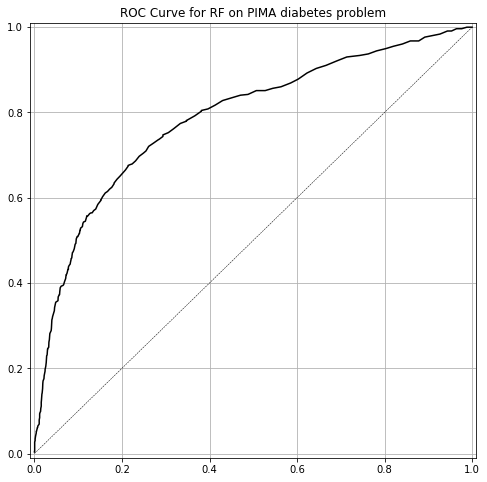

In [192]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [248]:
def plot_model_train_validation_loss(keras_model):
       #plot accuracy of second deep learning model
    fig, ax = plt.subplots()
    ax.plot(keras_model.history["loss"],'r', marker='.', label="Train Loss")
    ax.plot(keras_model.history["val_loss"],'b', marker='.', label="Validation Loss")
    ax.legend()
    
def model_compute_test_validation_accuracy(keras_model):    
    y_pred_class_nn_1 = keras_model.predict_classes(X_test_norm)
    y_pred_prob_nn_1 = keras_model.predict(X_test_norm)

    # Print model performance and plot the roc curve
    print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
    print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))
    plot_roc(y_test, y_pred_prob_nn_1, 'NN')
    
def output_labels_given_model_data(keras_model, credit_cards_deep_learning_test):
    #firstly, normalize the test set
    X_data = normalizer.fit_transform(credit_cards_deep_learning_test)
    
    y_labels = keras_model.predict_classes(X_data)
    
    list_elements = np.arange(0, len(y_labels))

    
    #and now let's co
    
    return(list_elements, y_labels)  

In [193]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications


normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [197]:
# Define the Model 
# Input size is 9-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)


model_1 = Sequential([
    Dense(12, input_shape=(27,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [198]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 12)                336       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 13        
Total params: 349
Trainable params: 349
Non-trainable params: 0
_________________________________________________________________


In [199]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Train on 7477 samples, validate on 2493 samples
Epoch 1/200
7477/7477 [==============================] - 0s 66us/step - loss: 0.6820 - acc: 0.5891 - val_loss: 0.5961 - val_acc: 0.6887
Epoch 2/200
7477/7477 [==============================] - 0s 27us/step - loss: 0.5795 - acc: 0.7332 - val_loss: 0.5480 - val_acc: 0.7669
Epoch 3/200
7477/7477 [==============================] - 0s 33us/step - loss: 0.5487 - acc: 0.7769 - val_loss: 0.5272 - val_acc: 0.7838
Epoch 4/200
7477/7477 [==============================] - 0s 40us/step - loss: 0.5329 - acc: 0.7907 - val_loss: 0.5145 - val_acc: 0.7886
Epoch 5/200
7477/7477 [==============================] - 0s 41us/step - loss: 0.5221 - acc: 0.7956 - val_loss: 0.5057 - val_acc: 0.7954
Epoch 6/200
7477/7477 [==============================] - 0s 35us/step - loss: 0.5139 - acc: 0.7984 - val_loss: 0.4989 - val_acc: 0.8006
Epoch 7/200
7477/7477 [==============================] - 0s 32us/step - loss: 0.5072 - acc: 0.8003 - val_loss: 0.4933 - val_acc: 0.8043


7477/7477 [==============================] - 0s 36us/step - loss: 0.4463 - acc: 0.8109 - val_loss: 0.4441 - val_acc: 0.8143
Epoch 61/200
7477/7477 [==============================] - 0s 32us/step - loss: 0.4461 - acc: 0.8106 - val_loss: 0.4440 - val_acc: 0.8143
Epoch 62/200
7477/7477 [==============================] - 0s 33us/step - loss: 0.4459 - acc: 0.8110 - val_loss: 0.4439 - val_acc: 0.8135
Epoch 63/200
7477/7477 [==============================] - 0s 29us/step - loss: 0.4457 - acc: 0.8109 - val_loss: 0.4437 - val_acc: 0.8139
Epoch 64/200
7477/7477 [==============================] - 0s 29us/step - loss: 0.4455 - acc: 0.8110 - val_loss: 0.4435 - val_acc: 0.8143
Epoch 65/200
7477/7477 [==============================] - 0s 27us/step - loss: 0.4453 - acc: 0.8108 - val_loss: 0.4433 - val_acc: 0.8135
Epoch 66/200
7477/7477 [==============================] - 0s 29us/step - loss: 0.4452 - acc: 0.8108 - val_loss: 0.4433 - val_acc: 0.8139
Epoch 67/200
7477/7477 [==============================

Epoch 120/200
7477/7477 [==============================] - 0s 45us/step - loss: 0.4399 - acc: 0.8164 - val_loss: 0.4388 - val_acc: 0.8183
Epoch 121/200
7477/7477 [==============================] - 0s 27us/step - loss: 0.4398 - acc: 0.8168 - val_loss: 0.4386 - val_acc: 0.8183
Epoch 122/200
7477/7477 [==============================] - 0s 36us/step - loss: 0.4398 - acc: 0.8164 - val_loss: 0.4387 - val_acc: 0.8175
Epoch 123/200
7477/7477 [==============================] - 0s 31us/step - loss: 0.4397 - acc: 0.8169 - val_loss: 0.4387 - val_acc: 0.8171
Epoch 124/200
7477/7477 [==============================] - 0s 40us/step - loss: 0.4396 - acc: 0.8172 - val_loss: 0.4386 - val_acc: 0.8175
Epoch 125/200
7477/7477 [==============================] - 0s 28us/step - loss: 0.4396 - acc: 0.8173 - val_loss: 0.4387 - val_acc: 0.8171
Epoch 126/200
7477/7477 [==============================] - 0s 40us/step - loss: 0.4395 - acc: 0.8174 - val_loss: 0.4384 - val_acc: 0.8167
Epoch 127/200
7477/7477 [=========

7477/7477 [==============================] - 0s 27us/step - loss: 0.4367 - acc: 0.8186 - val_loss: 0.4371 - val_acc: 0.8183
Epoch 180/200
7477/7477 [==============================] - 0s 38us/step - loss: 0.4367 - acc: 0.8188 - val_loss: 0.4371 - val_acc: 0.8183
Epoch 181/200
7477/7477 [==============================] - 0s 47us/step - loss: 0.4366 - acc: 0.8197 - val_loss: 0.4366 - val_acc: 0.8175
Epoch 182/200
7477/7477 [==============================] - 0s 29us/step - loss: 0.4366 - acc: 0.8192 - val_loss: 0.4366 - val_acc: 0.8167
Epoch 183/200
7477/7477 [==============================] - 0s 29us/step - loss: 0.4366 - acc: 0.8190 - val_loss: 0.4365 - val_acc: 0.8167
Epoch 184/200
7477/7477 [==============================] - 0s 29us/step - loss: 0.4365 - acc: 0.8190 - val_loss: 0.4367 - val_acc: 0.8171
Epoch 185/200
7477/7477 [==============================] - 0s 30us/step - loss: 0.4365 - acc: 0.8189 - val_loss: 0.4366 - val_acc: 0.8167
Epoch 186/200
7477/7477 [=======================

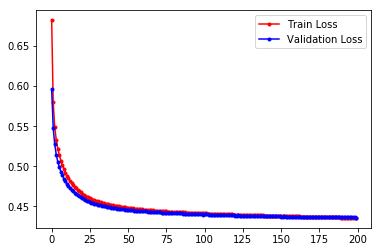

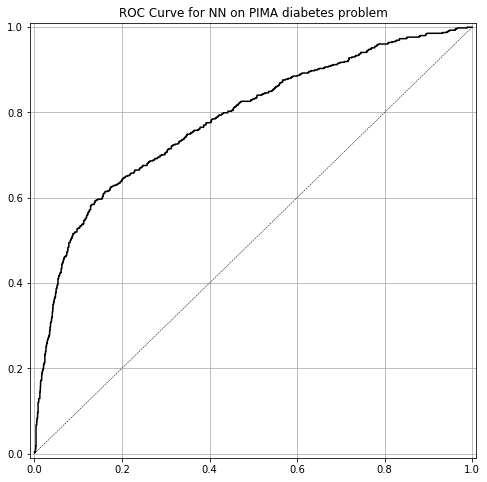

In [203]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

plot_model_train_validation_loss(run_hist_1)

plot_roc(y_test, y_pred_prob_nn_1, 'NN')


Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [147]:
run_hist_1.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

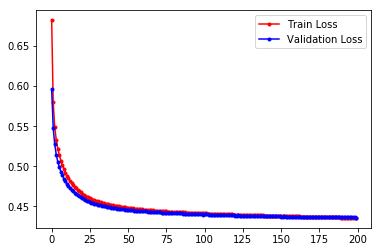

In [204]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [205]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Train on 7477 samples, validate on 2493 samples
Epoch 1/1000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4356 - acc: 0.8198 - val_loss: 0.4361 - val_acc: 0.8163
Epoch 2/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4356 - acc: 0.8201 - val_loss: 0.4361 - val_acc: 0.8163
Epoch 3/1000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4355 - acc: 0.8201 - val_loss: 0.4361 - val_acc: 0.8167
Epoch 4/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4355 - acc: 0.8202 - val_loss: 0.4362 - val_acc: 0.8167
Epoch 5/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4354 - acc: 0.8201 - val_loss: 0.4363 - val_acc: 0.8171
Epoch 6/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4354 - acc: 0.8197 - val_loss: 0.4361 - val_acc: 0.8167
Epoch 7/1000
7477/7477 [==============================] - 0s 32us/step - loss: 0.4353 - acc: 0.8204 - val_loss: 0.4359 - val_acc: 

7477/7477 [==============================] - 0s 37us/step - loss: 0.4331 - acc: 0.8216 - val_loss: 0.4345 - val_acc: 0.8171
Epoch 61/1000
7477/7477 [==============================] - 0s 32us/step - loss: 0.4330 - acc: 0.8215 - val_loss: 0.4346 - val_acc: 0.8163
Epoch 62/1000
7477/7477 [==============================] - 0s 36us/step - loss: 0.4330 - acc: 0.8212 - val_loss: 0.4347 - val_acc: 0.8171
Epoch 63/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4329 - acc: 0.8204 - val_loss: 0.4348 - val_acc: 0.8171
Epoch 64/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4329 - acc: 0.8216 - val_loss: 0.4343 - val_acc: 0.8175
Epoch 65/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4329 - acc: 0.8212 - val_loss: 0.4344 - val_acc: 0.8171
Epoch 66/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4328 - acc: 0.8215 - val_loss: 0.4344 - val_acc: 0.8171
Epoch 67/1000
7477/7477 [=======================

7477/7477 [==============================] - 0s 28us/step - loss: 0.4309 - acc: 0.8227 - val_loss: 0.4329 - val_acc: 0.8171
Epoch 120/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4309 - acc: 0.8227 - val_loss: 0.4332 - val_acc: 0.8175
Epoch 121/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4308 - acc: 0.8220 - val_loss: 0.4330 - val_acc: 0.8179
Epoch 122/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4308 - acc: 0.8229 - val_loss: 0.4330 - val_acc: 0.8175
Epoch 123/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4307 - acc: 0.8211 - val_loss: 0.4331 - val_acc: 0.8175
Epoch 124/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4307 - acc: 0.8227 - val_loss: 0.4333 - val_acc: 0.8171
Epoch 125/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4307 - acc: 0.8221 - val_loss: 0.4329 - val_acc: 0.8175
Epoch 126/1000
7477/7477 [================

7477/7477 [==============================] - 0s 26us/step - loss: 0.4289 - acc: 0.8220 - val_loss: 0.4323 - val_acc: 0.8187
Epoch 179/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4288 - acc: 0.8221 - val_loss: 0.4321 - val_acc: 0.8163
Epoch 180/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4288 - acc: 0.8211 - val_loss: 0.4321 - val_acc: 0.8191
Epoch 181/1000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4288 - acc: 0.8223 - val_loss: 0.4321 - val_acc: 0.8183
Epoch 182/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4287 - acc: 0.8216 - val_loss: 0.4318 - val_acc: 0.8175
Epoch 183/1000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4288 - acc: 0.8211 - val_loss: 0.4323 - val_acc: 0.8183
Epoch 184/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4287 - acc: 0.8225 - val_loss: 0.4319 - val_acc: 0.8187
Epoch 185/1000
7477/7477 [================

7477/7477 [==============================] - 0s 26us/step - loss: 0.4276 - acc: 0.8231 - val_loss: 0.4317 - val_acc: 0.8179
Epoch 238/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4275 - acc: 0.8219 - val_loss: 0.4318 - val_acc: 0.8179
Epoch 239/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4275 - acc: 0.8227 - val_loss: 0.4315 - val_acc: 0.8171
Epoch 240/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4275 - acc: 0.8225 - val_loss: 0.4314 - val_acc: 0.8179
Epoch 241/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4274 - acc: 0.8233 - val_loss: 0.4317 - val_acc: 0.8179
Epoch 242/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4274 - acc: 0.8225 - val_loss: 0.4315 - val_acc: 0.8175
Epoch 243/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4274 - acc: 0.8225 - val_loss: 0.4315 - val_acc: 0.8163
Epoch 244/1000
7477/7477 [================

7477/7477 [==============================] - 0s 25us/step - loss: 0.4263 - acc: 0.8227 - val_loss: 0.4309 - val_acc: 0.8179
Epoch 297/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4262 - acc: 0.8227 - val_loss: 0.4308 - val_acc: 0.8179
Epoch 298/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4262 - acc: 0.8227 - val_loss: 0.4308 - val_acc: 0.8179
Epoch 299/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4262 - acc: 0.8225 - val_loss: 0.4309 - val_acc: 0.8175
Epoch 300/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4261 - acc: 0.8224 - val_loss: 0.4312 - val_acc: 0.8175
Epoch 301/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4262 - acc: 0.8225 - val_loss: 0.4312 - val_acc: 0.8175
Epoch 302/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4261 - acc: 0.8217 - val_loss: 0.4308 - val_acc: 0.8175
Epoch 303/1000
7477/7477 [================

7477/7477 [==============================] - 0s 28us/step - loss: 0.4252 - acc: 0.8225 - val_loss: 0.4302 - val_acc: 0.8179
Epoch 356/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4251 - acc: 0.8232 - val_loss: 0.4305 - val_acc: 0.8179
Epoch 357/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4250 - acc: 0.8223 - val_loss: 0.4300 - val_acc: 0.8191
Epoch 358/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4251 - acc: 0.8221 - val_loss: 0.4304 - val_acc: 0.8183
Epoch 359/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4251 - acc: 0.8232 - val_loss: 0.4305 - val_acc: 0.8187
Epoch 360/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4251 - acc: 0.8224 - val_loss: 0.4301 - val_acc: 0.8183
Epoch 361/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4251 - acc: 0.8227 - val_loss: 0.4300 - val_acc: 0.8187
Epoch 362/1000
7477/7477 [================

Epoch 414/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4242 - acc: 0.8229 - val_loss: 0.4297 - val_acc: 0.8215
Epoch 415/1000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4242 - acc: 0.8221 - val_loss: 0.4302 - val_acc: 0.8199
Epoch 416/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4241 - acc: 0.8224 - val_loss: 0.4296 - val_acc: 0.8199
Epoch 417/1000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4241 - acc: 0.8217 - val_loss: 0.4303 - val_acc: 0.8195
Epoch 418/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4242 - acc: 0.8224 - val_loss: 0.4304 - val_acc: 0.8199
Epoch 419/1000
7477/7477 [==============================] - 0s 30us/step - loss: 0.4241 - acc: 0.8225 - val_loss: 0.4297 - val_acc: 0.8211
Epoch 420/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4242 - acc: 0.8225 - val_loss: 0.4301 - val_acc: 0.8207
Epoch 421/1000
7477/7477 [=

Epoch 473/1000
7477/7477 [==============================] - 0s 35us/step - loss: 0.4235 - acc: 0.8233 - val_loss: 0.4302 - val_acc: 0.8203
Epoch 474/1000
7477/7477 [==============================] - 0s 38us/step - loss: 0.4235 - acc: 0.8236 - val_loss: 0.4303 - val_acc: 0.8211
Epoch 475/1000
7477/7477 [==============================] - 0s 36us/step - loss: 0.4235 - acc: 0.8227 - val_loss: 0.4301 - val_acc: 0.8203
Epoch 476/1000
7477/7477 [==============================] - 0s 37us/step - loss: 0.4235 - acc: 0.8229 - val_loss: 0.4302 - val_acc: 0.8203
Epoch 477/1000
7477/7477 [==============================] - 0s 45us/step - loss: 0.4234 - acc: 0.8228 - val_loss: 0.4298 - val_acc: 0.8215
Epoch 478/1000
7477/7477 [==============================] - 0s 30us/step - loss: 0.4235 - acc: 0.8233 - val_loss: 0.4298 - val_acc: 0.8211
Epoch 479/1000
7477/7477 [==============================] - 0s 32us/step - loss: 0.4234 - acc: 0.8235 - val_loss: 0.4298 - val_acc: 0.8211
Epoch 480/1000
7477/7477 [=

Epoch 532/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4228 - acc: 0.8231 - val_loss: 0.4302 - val_acc: 0.8203
Epoch 533/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4228 - acc: 0.8243 - val_loss: 0.4304 - val_acc: 0.8203
Epoch 534/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4228 - acc: 0.8227 - val_loss: 0.4302 - val_acc: 0.8199
Epoch 535/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4228 - acc: 0.8231 - val_loss: 0.4304 - val_acc: 0.8211
Epoch 536/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4228 - acc: 0.8227 - val_loss: 0.4305 - val_acc: 0.8195
Epoch 537/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4227 - acc: 0.8228 - val_loss: 0.4299 - val_acc: 0.8219
Epoch 538/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4228 - acc: 0.8235 - val_loss: 0.4307 - val_acc: 0.8195
Epoch 539/1000
7477/7477 [=

Epoch 591/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4222 - acc: 0.8235 - val_loss: 0.4312 - val_acc: 0.8223
Epoch 592/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4223 - acc: 0.8244 - val_loss: 0.4304 - val_acc: 0.8215
Epoch 593/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4222 - acc: 0.8243 - val_loss: 0.4306 - val_acc: 0.8215
Epoch 594/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4222 - acc: 0.8237 - val_loss: 0.4302 - val_acc: 0.8207
Epoch 595/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4222 - acc: 0.8233 - val_loss: 0.4308 - val_acc: 0.8215
Epoch 596/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4221 - acc: 0.8236 - val_loss: 0.4299 - val_acc: 0.8211
Epoch 597/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4222 - acc: 0.8243 - val_loss: 0.4303 - val_acc: 0.8215
Epoch 598/1000
7477/7477 [=

Epoch 650/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4217 - acc: 0.8229 - val_loss: 0.4306 - val_acc: 0.8203
Epoch 651/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4217 - acc: 0.8228 - val_loss: 0.4310 - val_acc: 0.8207
Epoch 652/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4215 - acc: 0.8240 - val_loss: 0.4298 - val_acc: 0.8219
Epoch 653/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4217 - acc: 0.8233 - val_loss: 0.4298 - val_acc: 0.8215
Epoch 654/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4217 - acc: 0.8243 - val_loss: 0.4303 - val_acc: 0.8203
Epoch 655/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4217 - acc: 0.8237 - val_loss: 0.4306 - val_acc: 0.8207
Epoch 656/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4217 - acc: 0.8244 - val_loss: 0.4305 - val_acc: 0.8207
Epoch 657/1000
7477/7477 [=

Epoch 709/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4213 - acc: 0.8236 - val_loss: 0.4308 - val_acc: 0.8199
Epoch 710/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4214 - acc: 0.8236 - val_loss: 0.4304 - val_acc: 0.8199
Epoch 711/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4213 - acc: 0.8227 - val_loss: 0.4308 - val_acc: 0.8207
Epoch 712/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4213 - acc: 0.8232 - val_loss: 0.4308 - val_acc: 0.8203
Epoch 713/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4213 - acc: 0.8233 - val_loss: 0.4308 - val_acc: 0.8199
Epoch 714/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4213 - acc: 0.8239 - val_loss: 0.4305 - val_acc: 0.8199
Epoch 715/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4213 - acc: 0.8240 - val_loss: 0.4306 - val_acc: 0.8199
Epoch 716/1000
7477/7477 [=

Epoch 768/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4209 - acc: 0.8229 - val_loss: 0.4303 - val_acc: 0.8211
Epoch 769/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4209 - acc: 0.8233 - val_loss: 0.4305 - val_acc: 0.8207
Epoch 770/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4208 - acc: 0.8239 - val_loss: 0.4317 - val_acc: 0.8211
Epoch 771/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4210 - acc: 0.8229 - val_loss: 0.4307 - val_acc: 0.8215
Epoch 772/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4209 - acc: 0.8228 - val_loss: 0.4304 - val_acc: 0.8203
Epoch 773/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4209 - acc: 0.8233 - val_loss: 0.4307 - val_acc: 0.8215
Epoch 774/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4208 - acc: 0.8229 - val_loss: 0.4302 - val_acc: 0.8211
Epoch 775/1000
7477/7477 [=

Epoch 827/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4206 - acc: 0.8224 - val_loss: 0.4310 - val_acc: 0.8203
Epoch 828/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4206 - acc: 0.8225 - val_loss: 0.4308 - val_acc: 0.8203
Epoch 829/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4206 - acc: 0.8227 - val_loss: 0.4308 - val_acc: 0.8203
Epoch 830/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4206 - acc: 0.8233 - val_loss: 0.4306 - val_acc: 0.8207
Epoch 831/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4206 - acc: 0.8232 - val_loss: 0.4306 - val_acc: 0.8207
Epoch 832/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4205 - acc: 0.8227 - val_loss: 0.4301 - val_acc: 0.8203
Epoch 833/1000
7477/7477 [==============================] - 0s 34us/step - loss: 0.4206 - acc: 0.8224 - val_loss: 0.4308 - val_acc: 0.8199
Epoch 834/1000
7477/7477 [=

Epoch 886/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4202 - acc: 0.8225 - val_loss: 0.4312 - val_acc: 0.8215
Epoch 887/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4202 - acc: 0.8215 - val_loss: 0.4306 - val_acc: 0.8207
Epoch 888/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4202 - acc: 0.8217 - val_loss: 0.4303 - val_acc: 0.8199
Epoch 889/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4202 - acc: 0.8229 - val_loss: 0.4312 - val_acc: 0.8211
Epoch 890/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4202 - acc: 0.8228 - val_loss: 0.4304 - val_acc: 0.8203
Epoch 891/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4200 - acc: 0.8229 - val_loss: 0.4314 - val_acc: 0.8203
Epoch 892/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4203 - acc: 0.8227 - val_loss: 0.4312 - val_acc: 0.8203
Epoch 893/1000
7477/7477 [=

Epoch 945/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4199 - acc: 0.8232 - val_loss: 0.4306 - val_acc: 0.8207
Epoch 946/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4199 - acc: 0.8228 - val_loss: 0.4308 - val_acc: 0.8199
Epoch 947/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4199 - acc: 0.8228 - val_loss: 0.4309 - val_acc: 0.8199
Epoch 948/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4199 - acc: 0.8233 - val_loss: 0.4313 - val_acc: 0.8199
Epoch 949/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4198 - acc: 0.8225 - val_loss: 0.4301 - val_acc: 0.8191
Epoch 950/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4199 - acc: 0.8225 - val_loss: 0.4307 - val_acc: 0.8207
Epoch 951/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4198 - acc: 0.8239 - val_loss: 0.4301 - val_acc: 0.8199
Epoch 952/1000
7477/7477 [=

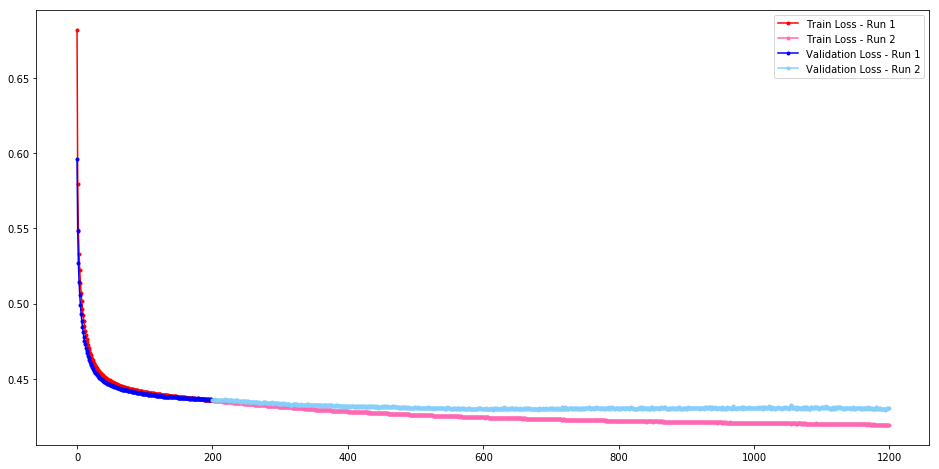

In [206]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

accuracy is 0.820
roc-auc is 0.791


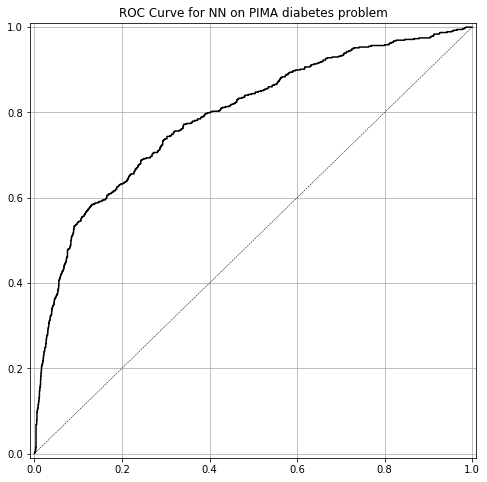

In [210]:
model_compute_test_validation_accuracy(model_1)

In [253]:
list_labels, y_labels = output_labels_given_model_data(model_1, credit_cards_deep_learning_test)
#len(y_labels)



def number_to_default(number):
    if number == 0:
        return "no"
    elif number == 1:
        return "yes"

def output_results_to_file(file_name, y_labels):
    sys.stdout = open(file_name, 'w')
    #just iterate over the two lists element by element
    print("index,credit_default")
    for i in range(0, len(y_labels)):
        print(str(i) + "," + str(number_to_default(y_labels.item(i))))



output_results_to_file("group_1_submission_3rd_try.txt", y_labels)

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## Exercise
Now it's your turn.  Do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures

In [258]:
1.# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 6 hidden nodes, relu activation
# 1 hidden layer, 6 hidden nodes, relu activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)


model_2 = Sequential([
    #hidden layers
    Dense(6, input_shape=(27,), activation="relu"),
    Dense(6, activation="relu"),
    #final layer
    Dense(1, activation="sigmoid")
])

In [259]:
model_2.summary()

In [260]:
model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])

In [263]:
#Train function!!
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)

# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

In [270]:
#model_compute_test_validation_accuracy(model_2)

#file
#sys.stdout = open(file_name, 'w')


y_pred_class_nn_1 = model_2.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_2.predict(X_test_norm)

# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))
